<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import pandas as pd
from sqlite3 import connect
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np

In [161]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

In [162]:
data = pd.read_csv(folder_path + "olist_customer_cleaned_data.csv")

In [163]:
data.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,1,86.22,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,1,18040,good (silver)


[link text](https://)

## La prévalence de la loyauté des clients

In [164]:
rfm_counts = data['rfm_segment_loyalty'].value_counts()

fig = px.pie(
    rfm_counts,
    values=rfm_counts.values,
    names=rfm_counts.index,
    title="Distribution des client par segment de Loyalty",
    hole=0
    )
fig.update_traces(textinfo="label+percent", textfont_size=12, rotation=90)
fig.update_layout(showlegend=True, legend_title_text="Segment de Loyalty")
fig.show()

## 1 | K-Means Clustering

In [165]:
kmeans_data = data.sample(20000, random_state=42).copy().copy()
customer_unique_id = kmeans_data.customer_unique_id
kmeans_data.drop(columns=['customer_unique_id', 'last_purch'], inplace=True)

## 1.2 | Enodage des features

In [166]:
categorical_columns = kmeans_data.select_dtypes(['category','object']).columns
numerical_columns = kmeans_data.select_dtypes(['int32','float64']).columns
ohe = OneHotEncoder()
ohe_df = pd.DataFrame(ohe.fit_transform(kmeans_data[categorical_columns]).toarray(), columns=ohe.get_feature_names_out())

In [167]:
ohe_df.isna().sum()

,0
rfm_segment_loyalty_good (silver),0
rfm_segment_loyalty_inactive,0
rfm_segment_loyalty_risk (bronze),0
rfm_segment_loyalty_top (Gold),0


In [168]:
kmeans_data = pd.merge(kmeans_data, ohe_df, left_index=True, right_index=True).drop(columns=['rfm_segment_loyalty', 'customer_zip_code_prefix', 'last_purch_day_of_week'])

In [169]:
kmeans_data

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,rfm_segment_loyalty_good (silver),rfm_segment_loyalty_inactive,rfm_segment_loyalty_risk (bronze),rfm_segment_loyalty_top (Gold)
502,151,1,98.60,6,312,1.0,1.0,1.0,1.0,0.0,0.0,0.0
19331,278,1,38.69,4,211,5.0,1.0,1.0,0.0,0.0,0.0,1.0
15397,226,1,32.90,4,211,5.0,1.0,1.0,1.0,0.0,0.0,0.0
2783,10,1,177.62,8,413,1.0,2.0,2.0,0.0,0.0,1.0,0.0
7316,130,1,48.42,5,311,4.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12639,430,1,38.10,3,111,5.0,1.0,1.0,0.0,0.0,0.0,1.0
12184,366,1,671.34,6,114,5.0,1.0,1.0,1.0,0.0,0.0,0.0
10332,275,1,45.01,4,211,5.0,1.0,1.0,0.0,1.0,0.0,0.0
646,232,1,142.92,6,213,2.0,1.0,1.0,0.0,1.0,0.0,0.0


### 1.2 | Standardisation

In [170]:
ss = StandardScaler()
kmeans_data = pd.DataFrame(ss.fit_transform(kmeans_data), columns=kmeans_data.columns)

In [171]:
kmeans_data

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,rfm_segment_loyalty_good (silver),rfm_segment_loyalty_inactive,rfm_segment_loyalty_risk (bronze),rfm_segment_loyalty_top (Gold)
0,-0.562393,-0.17069,-0.254062,-0.041186,0.418847,-2.441273,-0.275626,-0.174763,2.112494,-0.780993,-0.557096,-0.501916
1,0.260088,-0.17069,-0.451693,-1.189797,-0.477938,0.656150,-0.275626,-0.174763,-0.473374,-0.780993,-0.557096,1.992365
2,-0.076676,-0.17069,-0.470793,-1.189797,-0.477938,0.656150,-0.275626,-0.174763,2.112494,-0.780993,-0.557096,-0.501916
3,-1.475542,-0.17069,0.006608,1.107425,1.315633,-2.441273,1.831458,4.217454,-0.473374,-0.780993,1.795024,-0.501916
4,-0.698394,-0.17069,-0.419596,-0.615492,0.409968,-0.118205,-0.275626,-0.174763,-0.473374,-0.780993,-0.557096,1.992365
...,...,...,...,...,...,...,...,...,...,...,...,...
4234,1.244475,-0.17069,-0.453639,-1.764103,-1.365845,0.656150,-0.275626,-0.174763,-0.473374,-0.780993,-0.557096,1.992365
4235,0.829996,-0.17069,1.635287,-0.041186,-1.339208,0.656150,-0.275626,-0.174763,2.112494,-0.780993,-0.557096,-0.501916
4236,0.240659,-0.17069,-0.430844,-1.189797,-0.477938,0.656150,-0.275626,-0.174763,-0.473374,1.280421,-0.557096,-0.501916
4237,-0.037818,-0.17069,-0.107860,-0.041186,-0.460180,-1.666917,-0.275626,-0.174763,-0.473374,1.280421,-0.557096,-0.501916


## | 1.3 clustering avec les features rfm seulement

In [172]:
feats = ['recency', 'frequency', 'monetary', 'rfm_segment', 'satisfaction', 'rfm_score']
first_selection_df = kmeans_data[feats]

### 1.3.1 | recherche du k optimal

In [173]:
inertia = {}
dict_kmeans = {}
silhouette_scores = {}

for k in range(2,25):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(first_selection_df)
    cluster_labels = kmeans.predict(first_selection_df)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    silhouette_scores[k] = silhouette_score(first_selection_df, cluster_labels)

ks = np.array(list(inertia.keys()))
inertias = np.array(list(inertia.values()))
diff_inertia = np.diff(inertias, 2)
elbow_k = ks[np.argmin(diff_inertia)]

# Afficher le nombre de clusters optimal selon silhouette
best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"elbow_k={elbow_k}, best_silhouette_k={silhouette_scores[best_silhouette_k]}")

elbow_k=4, best_silhouette_k=0.6405276028274554


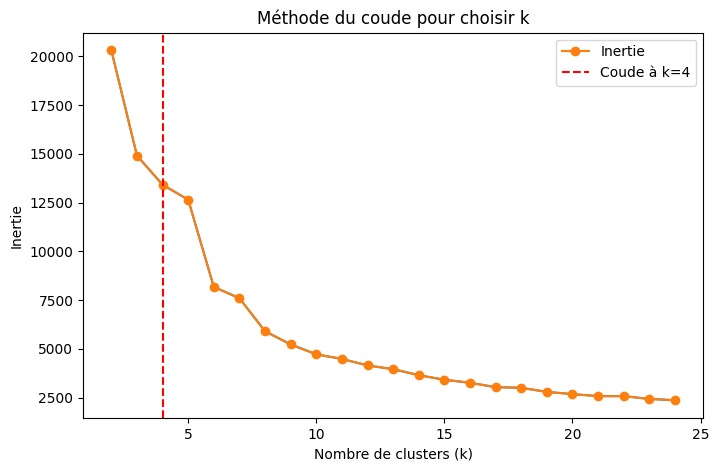

In [174]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison des inerties en fonction de k')

sns.lineplot(x=list(inertia.keys()), y=list(inertia.values()))

# Tracer la courbe d'inertie avec le coude
plt.plot(ks, inertias, marker="o", linestyle="-", label="Inertie")
plt.axvline(x=elbow_k, color="r", linestyle="--", label=f"Coude à k={elbow_k}")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour choisir k")

plt.legend()
plt.show()

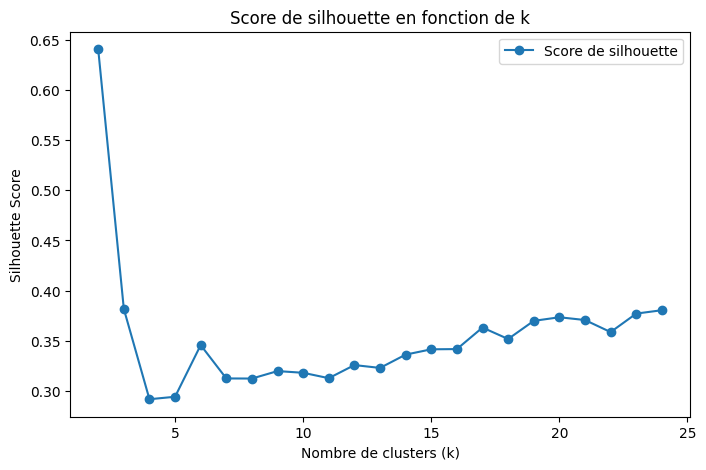

In [175]:
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-", label="Score de silhouette")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Score de silhouette en fonction de k")
plt.legend()
plt.show()

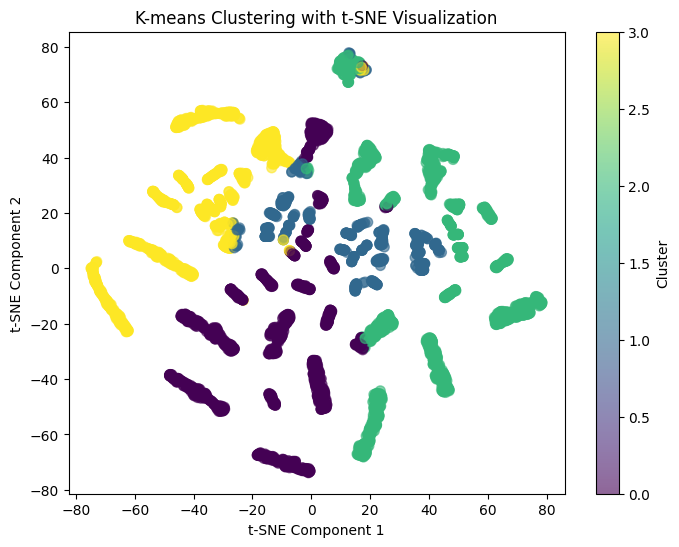

In [176]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(first_selection_df)
labels = kmeans.labels_

# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(first_selection_df)

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-means Clustering with t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

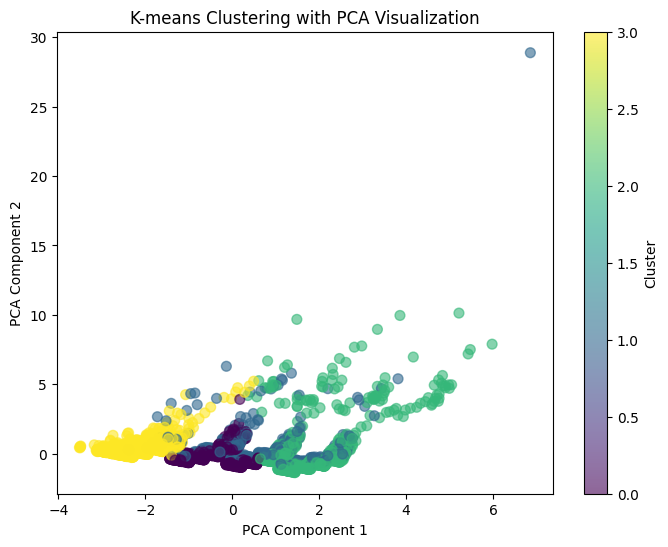

In [177]:
labels = kmeans.labels_
from sklearn.decomposition import PCA
# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(first_selection_df)

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

## | 1.4 clustering avec l'ensemble des features

In [178]:
X = kmeans_data.copy()

### 1.4.1 | recherche du k optimal

In [179]:
inertia = {}
dict_kmeans = {}
silhouette_scores = {}

for k in range(2,25):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    cluster_labels = kmeans.predict(X)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    silhouette_scores[k] = silhouette_score(X, cluster_labels)

ks = np.array(list(inertia.keys()))
inertias = np.array(list(inertia.values()))
diff_inertia = np.diff(inertias, 2)
elbow_k = ks[np.argmin(diff_inertia)]

# Afficher le nombre de clusters optimal selon silhouette
best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"elbow_k={elbow_k}, best_silhouette_k={silhouette_scores[best_silhouette_k]}")

elbow_k=12, best_silhouette_k=0.35630065027159435


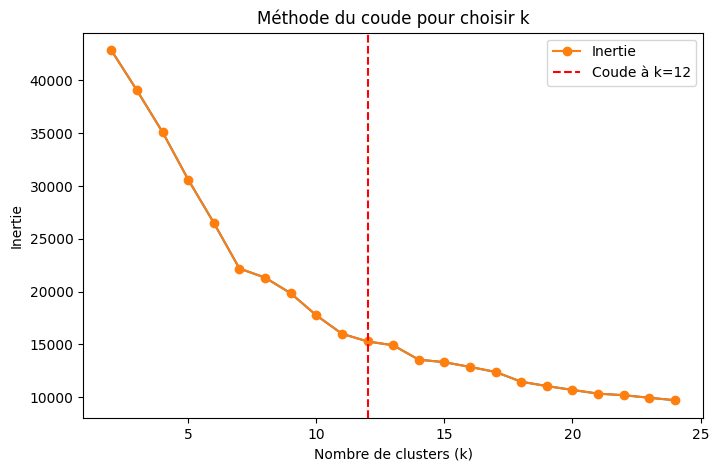

In [180]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison des inerties en fonction de k')

sns.lineplot(x=list(inertia.keys()), y=list(inertia.values()))

# Tracer la courbe d'inertie avec le coude
plt.plot(ks, inertias, marker="o", linestyle="-", label="Inertie")
plt.axvline(x=elbow_k, color="r", linestyle="--", label=f"Coude à k={elbow_k}")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour choisir k")

plt.legend()
plt.show()

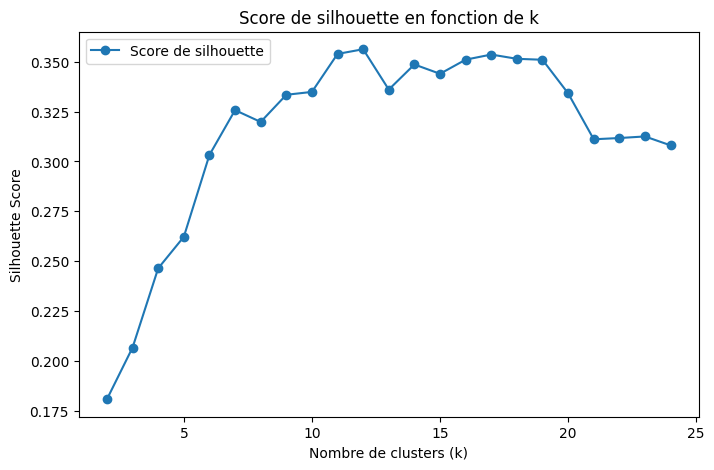

In [181]:
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-", label="Score de silhouette")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Score de silhouette en fonction de k")
plt.legend()
plt.show()

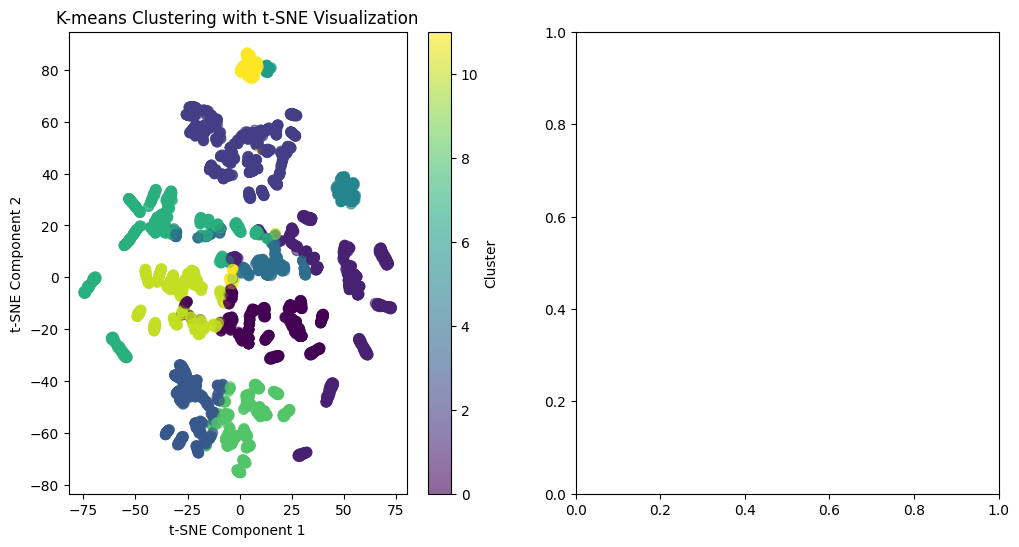

In [187]:
kmeans = KMeans(n_clusters=12, random_state=42).fit(X)
labels = kmeans.labels_

# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Visualiser les résultats
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
scatter = ax0.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
ax0.set_title('K-means Clustering with t-SNE Visualization')
ax0.set_xlabel('t-SNE Component 1')
ax0.set_ylabel('t-SNE Component 2')
fig.colorbar(scatter, ax=ax0, label='Cluster')


plt.show()

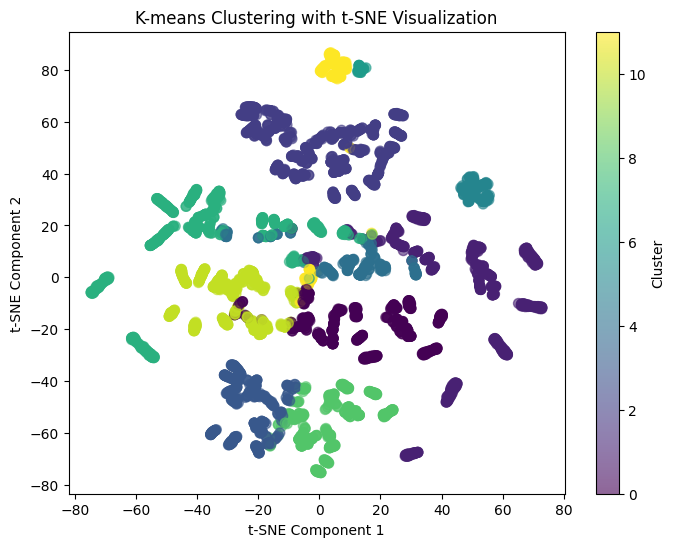

In [182]:
kmeans = KMeans(n_clusters=12, random_state=42).fit(X)
labels = kmeans.labels_

# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Visualiser les résultats
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
ax0.title('K-means Clustering with t-SNE Visualization')
ax0.set_xlabel('t-SNE Component 1')
ax0.set_ylabel('t-SNE Component 2')
ax0.colorbar(label='Cluster')
plt.show()

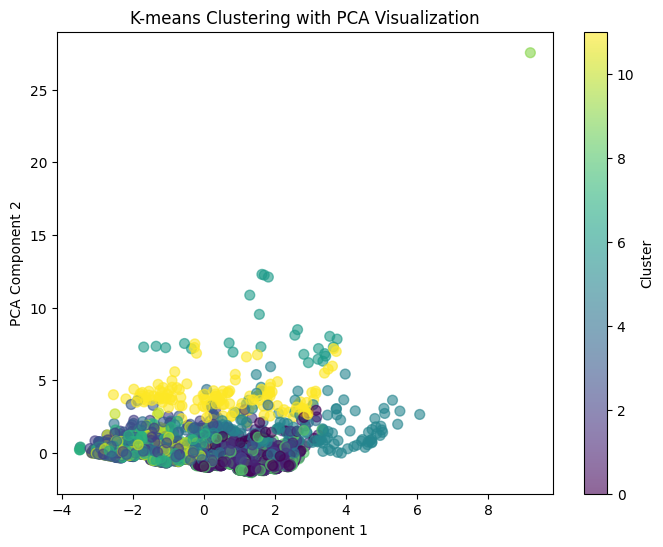

In [183]:

labels = kmeans.labels_
from sklearn.decomposition import PCA
# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Utilisation des radars plots pour une meilleure intrepretation des clusters